In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
from os import listdir
import pathlib
from random import randint
import numpy as np
from numpy import asarray
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
import tensorflow_addons as tfa
from keras.utils import load_img,img_to_array
from keras.models import Sequential
from tensorflow.keras.applications.inception_v3 import InceptionV3
from keras.layers import MaxPooling2D,Dropout,Dense,Input,Conv2D,Flatten,Conv2DTranspose
from keras.layers import GlobalAveragePooling2D,MaxPool2D,BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils import plot_model

In [2]:
folder = '/kaggle/input/alzheimer-mri-dataset/Dataset'
folder_path = pathlib.Path(folder)

<PIL.Image.Image image mode=RGB size=128x128 at 0x70E89329ED50>


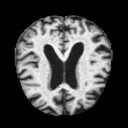

In [3]:
photo = load_img('/kaggle/input/alzheimer-mri-dataset/Dataset/Mild_Demented/mild.jpg')
print(photo)
photo

In [4]:
for file in listdir(folder):
    print(file)

Non_Demented
Mild_Demented
Moderate_Demented
Very_Mild_Demented


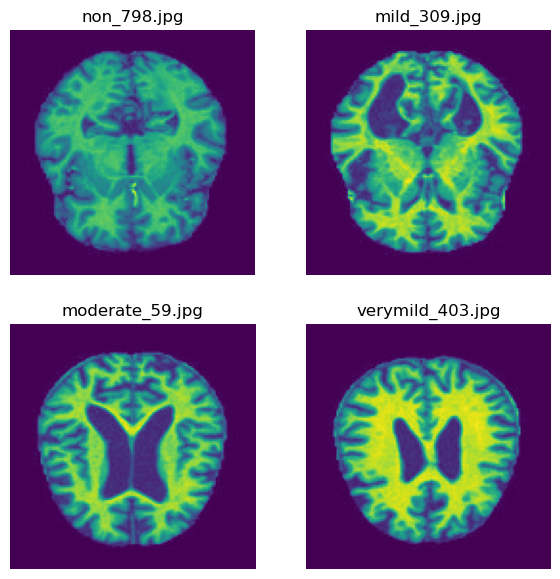

In [5]:
plt.figure(figsize=(7,7),)
j =0
for file in listdir(folder):
    i =0
    for image in listdir(folder + '/'+file):
        if i ==1:
            break;
        img = imread(folder +'/' + file + '/' + image)
        ax = plt.subplot(2,2,j+1)
        plt.imshow(img)
        plt.title(image)
        plt.axis('off')
        j = j+1
        i = i +1
plt.show()

In [6]:
# counting the number of images in each category
for file in listdir(folder):
    i =0
    for image in listdir(folder + '/'+file):
        i = i +1
    print(file , i)

Non_Demented 3200
Mild_Demented 896
Moderate_Demented 64
Very_Mild_Demented 2240


#### Here we can see that the dataset is completely imbalanced with different number of images in each category

In [7]:
# Creating the image datagenerator to have more samples
IMG_SIZE = 128
DIM = (IMG_SIZE, IMG_SIZE)

ZOOM = [.99, 1.01]
BRIGHT_RANGE = [0.8, 1.2]
HORZ_FLIP = True
FILL_MODE = "constant"
DATA_FORMAT = "channels_last"

In [8]:
train_generator = ImageDataGenerator(rescale = 1./255, brightness_range=BRIGHT_RANGE, zoom_range=ZOOM, 
                                     data_format=DATA_FORMAT, fill_mode=FILL_MODE, horizontal_flip=HORZ_FLIP)
train_data_gen = train_generator.flow_from_directory(directory=folder, target_size=DIM, batch_size=6500, shuffle=False)

Found 6400 images belonging to 4 classes.


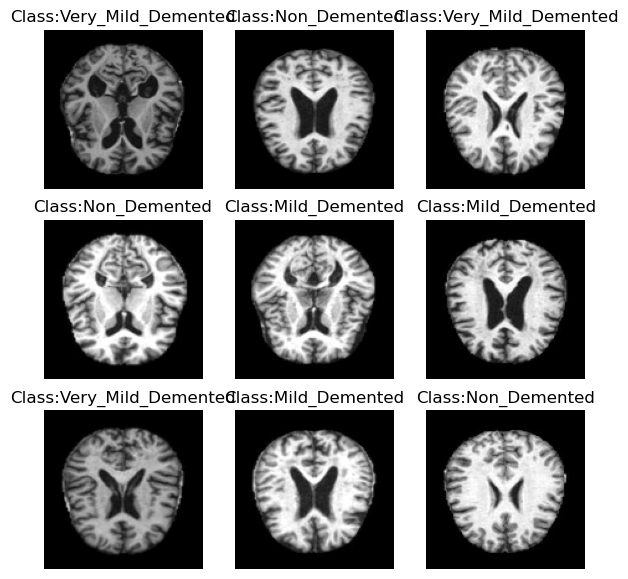

In [9]:
CLASSES = list(train_data_gen.class_indices.keys())

def show_images(generator,y_pred=None):
    # get image lables
    labels =dict(zip([0,1,2,3], CLASSES))
    
    # get a batch of images
    x,y = generator.next()
    
    # display a grid of 9 images
    plt.figure(figsize=(7, 7))
    if y_pred is None:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            idx = randint(0, 6400)
            plt.imshow(x[idx])
            plt.axis("off")
            plt.title("Class:{}".format(labels[np.argmax(y[idx])]))                                                    
    else:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(x[i])
            plt.axis("off")
            plt.title("Actual:{} \nPredicted:{}".format(labels[np.argmax(y[i])],labels[y_pred[i]]))
    
# Display Train Images
show_images(train_data_gen)

In [10]:
train_data, train_labels = train_data_gen.next()

In [11]:
train_data.shape, train_labels.shape

((6400, 128, 128, 3), (6400, 4))

Since the data in each class is imbalanced we need to oversample the data

In [12]:
sm = SMOTE(random_state=42)

train_data, train_labels = sm.fit_resample(train_data.reshape(-1, IMG_SIZE * IMG_SIZE * 3), train_labels)

print(train_data.shape, train_labels.shape)

(12800, 49152) (12800, 4)


In [13]:
train_data = train_data.reshape(-1, IMG_SIZE, IMG_SIZE, 3)
print(train_data.shape, train_labels.shape)

(12800, 128, 128, 3) (12800, 4)


In [14]:
train_data, test_data, train_labels,test_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)

train_data, val_data, train_labels,val_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)

In [15]:
# Defining convolutional blocks
def conv_block(filters, act='relu'):
    
    block = Sequential()
    block.add(Conv2D(filters, 3, activation=act, padding='same'))
    block.add(Conv2D(filters, 3, activation=act, padding='same'))
    block.add(BatchNormalization())
    block.add(MaxPool2D())
    
    return block

In [16]:
# defining dense blocks
def dense_block(units, dropout_rate, act='relu'):
    block = Sequential()
    block.add(Dense(units, activation=act))
    block.add(BatchNormalization())
    block.add(Dropout(dropout_rate))
    
    return block

In [17]:
IMAGE_SIZE = [128,128]
act = 'relu'

In [18]:
model = Sequential([
        Input(shape=(*IMAGE_SIZE, 3)),
        Conv2D(16, 3, activation=act, padding='same'),
        Conv2D(16, 3, activation=act, padding='same'),
        MaxPool2D(),
        conv_block(32),
        conv_block(64),
        conv_block(128),
        Dropout(0.2),
        conv_block(256),
        Dropout(0.2),
        Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        Dense(4, activation='softmax')        
    ], name = "cnn_model")


In [19]:
METRICS = [tf.keras.metrics.CategoricalAccuracy(name='acc'),
           tf.keras.metrics.AUC(name='auc'), 
           tfa.metrics.F1Score(num_classes=4)]

model.compile(optimizer='adam',
              loss=tf.losses.CategoricalCrossentropy(),
              metrics=METRICS)

model.summary()

Model: "cnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 16)      2320      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 16)       0         
 )                                                               
                                                                 
 sequential (Sequential)     (None, 32, 32, 32)        14016     
                                                                 
 sequential_1 (Sequential)   (None, 16, 16, 64)        55680     
                                                                 
 sequential_2 (Sequential)   (None, 8, 8, 128)         221952    
                                                         

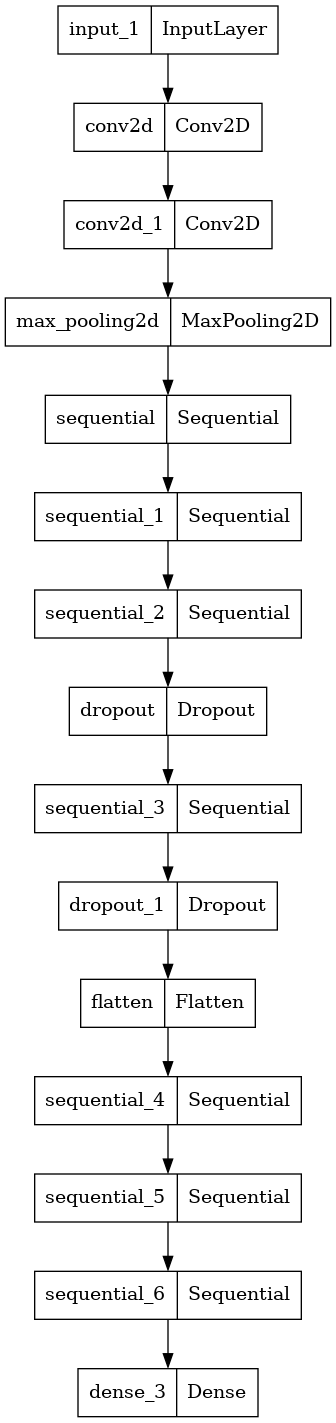

In [20]:
plot_model(model)

In [21]:
CALLBACKS = [
    EarlyStopping(monitor='accuracy', min_delta=0.01, patience=5, mode='max')
]

In [22]:
EPOCHS = 50

history = model.fit(train_data, train_labels, validation_data=(val_data, val_labels), epochs=EPOCHS,callbacks=CALLBACKS)

Epoch 1/50


2023-04-23 09:39:18.538367: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape incnn_model/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


256/256 [==============================] - 28s 41ms/step - loss: 1.6041 - acc: 0.3097 - auc: 0.5745 - f1_score: 0.3079 - val_loss: 6.3972 - val_acc: 0.2402 - val_auc: 0.5059 - val_f1_score: 0.0969
Epoch 2/50
256/256 [==============================] - 9s 36ms/step - loss: 1.0977 - acc: 0.5010 - auc: 0.7804 - f1_score: 0.4908 - val_loss: 8.9605 - val_acc: 0.2402 - val_auc: 0.5008 - val_f1_score: 0.0969
Epoch 3/50
256/256 [==============================] - 9s 35ms/step - loss: 0.8162 - acc: 0.6232 - auc: 0.8774 - f1_score: 0.6141 - val_loss: 1.0547 - val_acc: 0.4985 - val_auc: 0.8006 - val_f1_score: 0.4154
Epoch 4/50
256/256 [==============================] - 9s 36ms/step - loss: 0.7257 - acc: 0.6653 - auc: 0.9022 - f1_score: 0.6596 - val_loss: 4.3716 - val_acc: 0.2612 - val_auc: 0.5426 - val_f1_score: 0.1628
Epoch 5/50
256/256 [==============================] - 9s 36ms/step - loss: 0.6637 - acc: 0.6957 - auc: 0.9182 - f1_score: 0.6933 - val_loss: 0.6309 - val_acc: 0.7212 - val_auc: 0.928

In [23]:
test_scores = model.evaluate(test_data, test_labels)
print("Testing Accuracy: %.2f%%"%(test_scores[1] * 100))

80/80 [==============================] - 1s 11ms/step - loss: 0.3767 - acc: 0.9047 - auc: 0.9761 - f1_score: 0.9063
Testing Accuracy: 90.47%


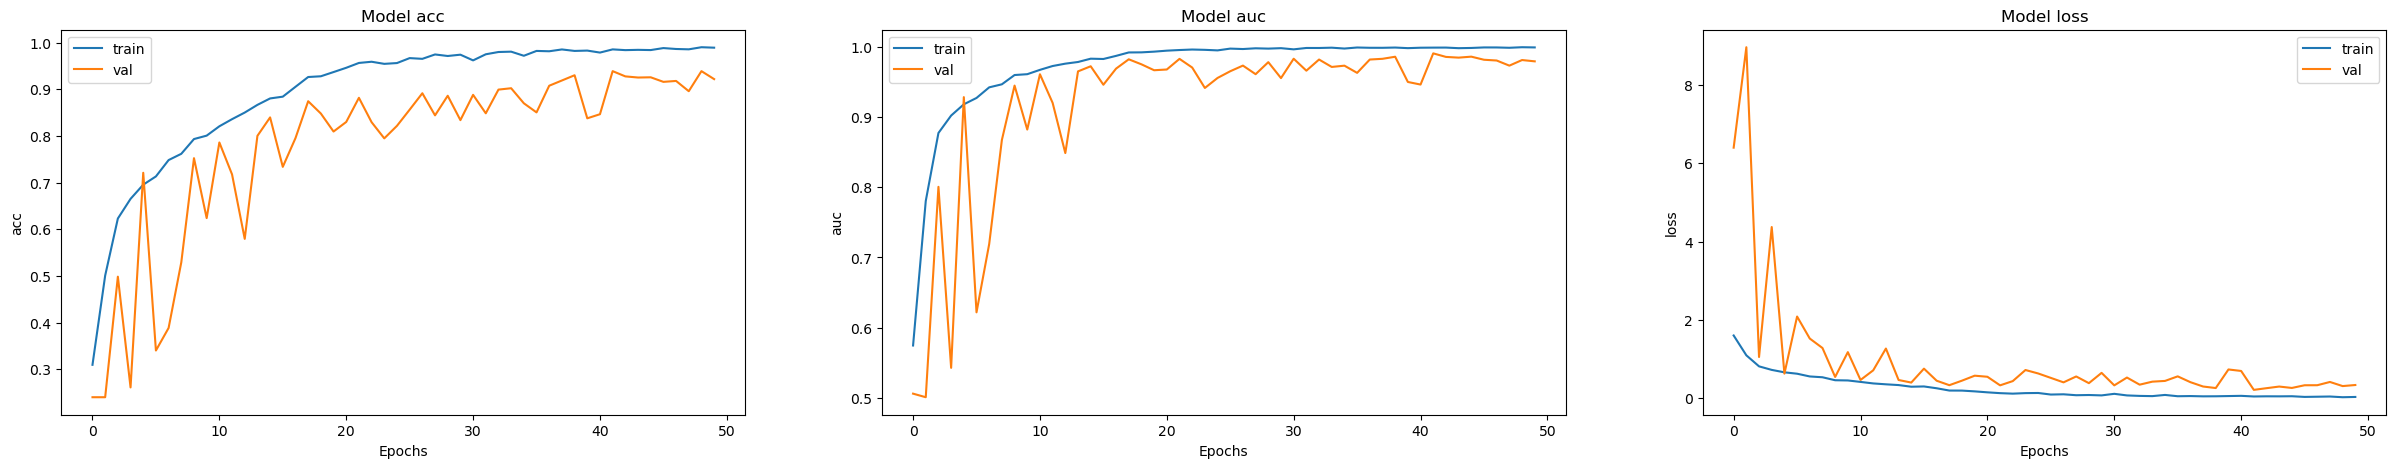

In [24]:
#Plotting the trend of the metrics during training

fig, ax = plt.subplots(1, 3, figsize = (30, 5))
ax = ax.ravel()

for i, metric in enumerate(["acc", "auc", "loss"]):
    ax[i].plot(history.history[metric])
    ax[i].plot(history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("Epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

## Transfer learning with Inceptionv3 model

In [25]:
inception = InceptionV3(input_shape=(128,128,3),include_top=False,weights ='imagenet')

87910968/87910968 [==============================] - 2s 0us/step


In [26]:
for layer in inception.layers:
    layer.trainable = False

In [27]:
inception_model = Sequential([
        inception,
        Dropout(0.5),
        GlobalAveragePooling2D(),
        Flatten(),
        BatchNormalization(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.5),
        BatchNormalization(),
        Dense(4, activation='softmax')        
    ], name = "inception_cnn_model")

In [28]:
inception_model.compile(optimizer='rmsprop',
                              loss=tf.losses.CategoricalCrossentropy(),
                              metrics=METRICS)

inception_model.summary()

Model: "inception_cnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 2, 2, 2048)        21802784  
                                                                 
 dropout_5 (Dropout)         (None, 2, 2, 2048)        0         
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 batch_normalization_101 (Ba  (None, 2048)             8192      
 tchNormalization)                                               
                                                                 
 dense_4 (Dense)             (None, 512)       

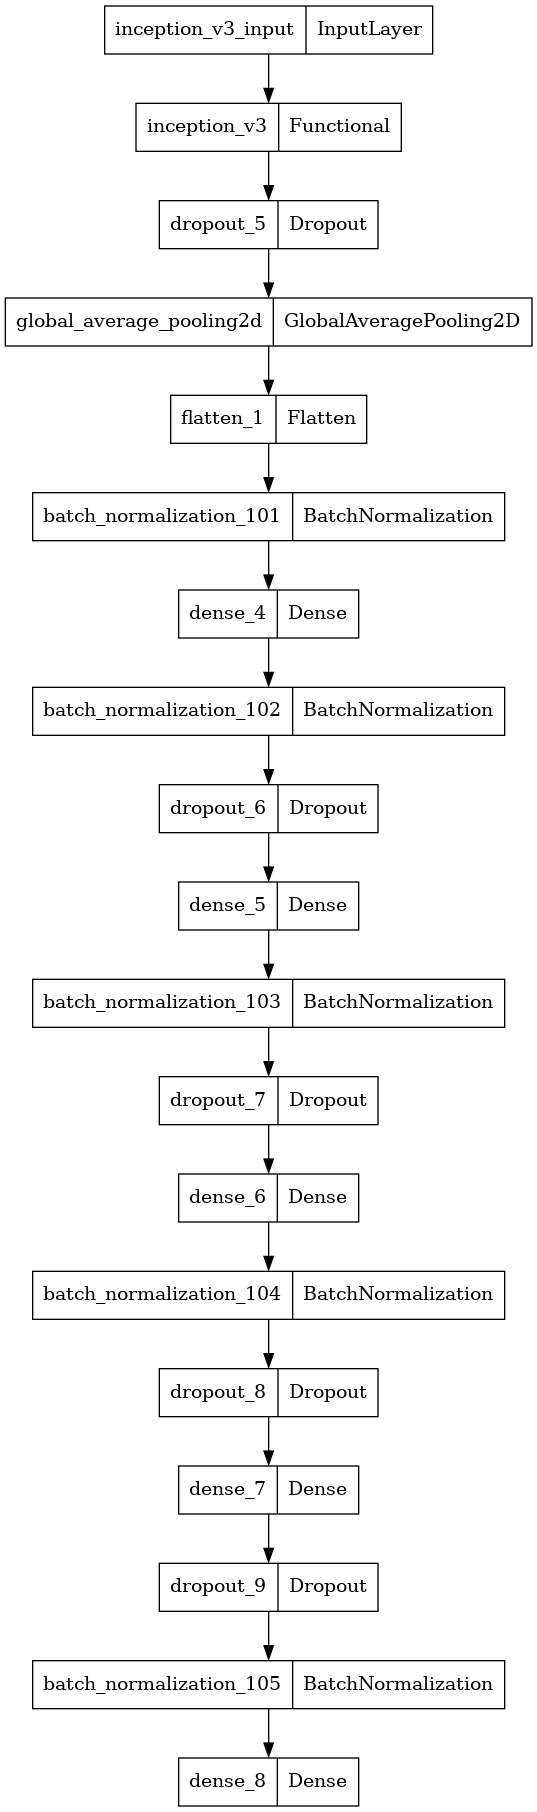

In [29]:
plot_model(inception_model)

In [30]:
INCEPT_CALLBACKS = [
    ModelCheckpoint(filepath='incpt_model_checkpoint.h5', save_best_only=True),
    EarlyStopping(patience=3)
]

In [31]:
incept_history = inception_model.fit(train_data, train_labels, validation_data=(val_data, val_labels), epochs=50,callbacks= INCEPT_CALLBACKS)

Epoch 1/50


2023-04-23 09:47:48.049738: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape ininception_cnn_model/dropout_5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


256/256 [==============================] - 21s 51ms/step - loss: 1.4530 - acc: 0.5150 - auc: 0.7796 - f1_score: 0.5131 - val_loss: 0.8447 - val_acc: 0.6030 - val_auc: 0.8668 - val_f1_score: 0.6010
Epoch 2/50
256/256 [==============================] - 11s 43ms/step - loss: 0.9979 - acc: 0.5411 - auc: 0.8197 - f1_score: 0.5354 - val_loss: 0.7435 - val_acc: 0.6450 - val_auc: 0.8942 - val_f1_score: 0.6376
Epoch 3/50
256/256 [==============================] - 10s 39ms/step - loss: 0.8578 - acc: 0.6039 - auc: 0.8650 - f1_score: 0.5974 - val_loss: 0.6933 - val_acc: 0.6753 - val_auc: 0.9091 - val_f1_score: 0.6660
Epoch 4/50
256/256 [==============================] - 11s 42ms/step - loss: 0.7847 - acc: 0.6433 - auc: 0.8872 - f1_score: 0.6359 - val_loss: 0.6572 - val_acc: 0.6899 - val_auc: 0.9185 - val_f1_score: 0.6831
Epoch 5/50
256/256 [==============================] - 10s 39ms/step - loss: 0.7512 - acc: 0.6625 - auc: 0.8977 - f1_score: 0.6584 - val_loss: 0.6387 - val_acc: 0.6958 - val_auc: 0

In [32]:
incept_test_scores = inception_model.evaluate(test_data, test_labels)
print("Testing Accuracy: %.2f%%"%(incept_test_scores[1] * 100))

80/80 [==============================] - 2s 29ms/step - loss: 0.3391 - acc: 0.8691 - auc: 0.9790 - f1_score: 0.8688
Testing Accuracy: 86.91%


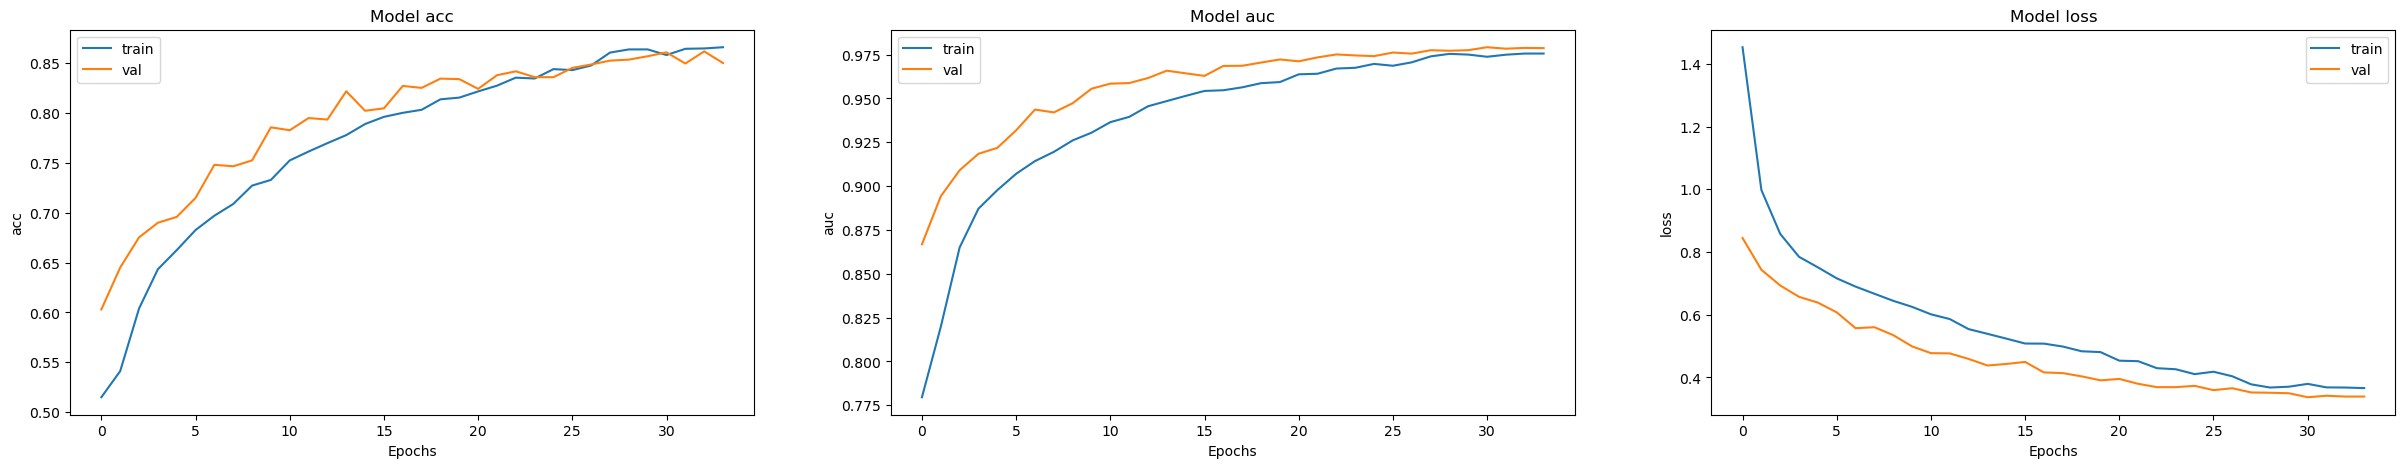

In [33]:
#Plotting the trend of the metrics during training

fig, ax = plt.subplots(1, 3, figsize = (30, 5))
ax = ax.ravel()

for i, metric in enumerate(["acc", "auc", "loss"]):
    ax[i].plot(incept_history.history[metric])
    ax[i].plot(incept_history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("Epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])